<a href="https://colab.research.google.com/github/i-m-vivek/deep-learning-mini_projects/blob/master/Image_Jigsaw_Solver_PyTorch_Model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip "/content/drive/My Drive/Image Jigsaw Dataset/data_kept.zip"

In [0]:
import torch 
import torch.nn.functional as F
from torch import nn 
from torch.utils import data as torch_data 
from torchvision import models, transforms
import torchvision

from tqdm import tqdm_notebook
from PIL import Image
import pandas as pd
import numpy as np 
import os 
import time
import copy
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [0]:
class JigsawDataset(torch_data.Dataset):
    """Dataset for Jigsaw Solving Task for 2*2 peices Images. 
    The Dataset will output a Image and 4 Numbers corresponding to the position of the peices."""

    def __init__(self, df, root_dir, transform):
        """
        Args: 
            df (pd.DataFrame): DataFrame with positions.
            root_dir (string): Path to the dir. where all images are present.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.df = df
        self.root_dir = root_dir
        self.transform = transform 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = str(self.df.iloc[idx, 2])
        img_name = "0"*(6 - len(img_name)) + img_name + ".jpg"
        img = Image.open(os.path.join(self.root_dir, img_name))

        perm = self.df.iloc[idx, 3]

        if self.transform is not None:
            img = self.transform(img)

        return {"img" : img, 
         "perm1": float(perm[2]),
        "perm2" : float(perm[7]),
        "perm3" : float(perm[12]),
        "perm4" : float(perm[17])}

In [0]:
composed_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
   transforms.RandomErasing(.3, )])

In [0]:
train = pd.read_csv("/content/drive/My Drive/Image Jigsaw Dataset/data_kept_50000.csv")

In [0]:
X_train, X_val = train_test_split(train, test_size= .2, random_state = 42, shuffle= True)

In [0]:
train_dataset = JigsawDataset(df = X_train,
                                           root_dir='/content/data_kept/',
                                           transform=composed_transform)
val_dataset = JigsawDataset(df = X_val, 
                                           root_dir='/content/data_kept/',
                                           transform=composed_transform)

In [0]:
trainloader = torch_data.DataLoader(train_dataset, batch_size= 16, shuffle=True)
valloader = torch_data.DataLoader(val_dataset, batch_size= 32, shuffle=False)

dataloaders = {"train": trainloader, 
               "val": valloader}
dataset_sizes = {"train":  len(train_dataset), 
                 "val": len(val_dataset)}

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

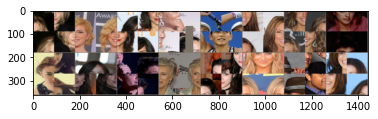

In [33]:
sample = next(iter(trainloader))
out = torchvision.utils.make_grid(sample["img"])
imshow(out)

In [0]:
# transformed_dataset = JigsawDataset(csv_file="/content/drive/My Drive/Image Jigsaw Dataset/data_kept_50000.csv",
#                                            root_dir='/content/data_kept/',
#                                            transform=composed_transform)
# for i in range(len(transformed_dataset)):
#     sample = transformed_dataset[i]

#     print(i, sample['img'].size(), sample["perm1"], sample["perm2"], sample["perm3"], sample["perm4"])

#     if i == 3:
#         break

0 torch.Size([3, 178, 178]) 3 2 1 0
1 torch.Size([3, 178, 178]) 0 2 1 3
2 torch.Size([3, 178, 178]) 1 3 2 0
3 torch.Size([3, 178, 178]) 0 1 3 2


In [0]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.vgg = models.vgg16_bn(pretrained=True)
        self.dropout = nn.Dropout(.4)
        self.Linear = nn.Linear(1000, 512)
        self.fc1 = nn.Linear(512, 4)
        self.fc2 = nn.Linear(512, 4)
        self.fc3 = nn.Linear(512, 4)
        self.fc4 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.dropout(F.relu(self.vgg(x)))
        x = self.Linear(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)

        return x1, x2, x3, x4
    

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
net = Net().to(device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
# from torchsummary import summary
# summary(net, (3, 178, 178))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 178, 178]           1,792
       BatchNorm2d-2         [-1, 64, 178, 178]             128
              ReLU-3         [-1, 64, 178, 178]               0
            Conv2d-4         [-1, 64, 178, 178]          36,928
       BatchNorm2d-5         [-1, 64, 178, 178]             128
              ReLU-6         [-1, 64, 178, 178]               0
         MaxPool2d-7           [-1, 64, 89, 89]               0
            Conv2d-8          [-1, 128, 89, 89]          73,856
       BatchNorm2d-9          [-1, 128, 89, 89]             256
             ReLU-10          [-1, 128, 89, 89]               0
           Conv2d-11          [-1, 128, 89, 89]         147,584
      BatchNorm2d-12          [-1, 128, 89, 89]             256
             ReLU-13          [-1, 128, 89, 89]               0
        MaxPool2d-14          [-1, 128,

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= .0001)

In [0]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inp_data in tqdm_notebook(dataloaders[phase]):
                inputs = inp_data["img"].to(device)

                label1 = inp_data["perm1"].to(device)
                label2 = inp_data["perm2"].to(device)
                label3 = inp_data["perm3"].to(device)
                label4 = inp_data["perm4"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    out1, out2, out3, out4 = model(inputs)
                    _, preds1 = torch.max(out1, 1)
                    _, preds2 = torch.max(out2, 1)
                    _, preds3 = torch.max(out3, 1)
                    _, preds4 = torch.max(out4, 1)
                    loss = criterion(out1, label1.long()) + criterion(out2, label2.long()) + criterion(out3, label3.long()) + criterion(out4, label4.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (torch.sum(preds1 == label1.data) + torch.sum(preds2 == label2.data) + torch.sum(preds3 == label3.data)+ torch.sum(preds4 == label4.data))/4
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
model_ft = train_model(net, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------



train Loss: 0.0238 Acc: 0.9957



val Loss: 0.0087 Acc: 0.9984

Training complete in 7m 22s
Best val Acc: 0.998400


In [0]:
sample_loader = torch_data.DataLoader(val_dataset, batch_size= 4, shuffle=False)

In [0]:
sample_iter = iter(sample_loader)

In [0]:
sample_data = next(sample_iter)

In [50]:
sample_data

{'img': tensor([[[[ 1.6324,  1.6324,  1.6324,  ...,  2.0605,  1.9064,  1.9064],
           [ 1.6324,  1.6324,  1.6153,  ...,  1.9578,  1.9578,  1.9578],
           [ 1.6324,  1.6153,  1.6153,  ...,  1.9920,  2.0605,  2.0605],
           ...,
           [ 2.0605,  2.0605,  1.9920,  ...,  1.6495,  1.5639,  1.5639],
           [ 1.9749,  1.9407,  1.8893,  ...,  1.4954,  1.4269,  1.4098],
           [ 1.9749,  1.9407,  1.8893,  ...,  1.4954,  1.4269,  1.4098]],
 
          [[ 1.8859,  1.8859,  1.8859,  ...,  1.4832,  1.4132,  1.4132],
           [ 1.8859,  1.8859,  1.8683,  ...,  1.4657,  1.5182,  1.5182],
           [ 1.8859,  1.8683,  1.8683,  ...,  1.5882,  1.6232,  1.6232],
           ...,
           [ 2.1310,  2.1660,  2.1310,  ...,  0.9405,  0.9230,  0.9230],
           [ 2.2185,  2.1835,  2.1310,  ...,  0.8354,  0.7829,  0.7654],
           [ 2.2185,  2.1835,  2.1310,  ...,  0.8354,  0.7829,  0.7654]],
 
          [[ 2.0300,  2.0300,  2.0300,  ...,  1.5420,  1.6117,  1.6117],
      

In [0]:
sample_preds = model_ft(sample_data["img"].to(device))

In [0]:
_, sample_preds_ = torch.max((sample_preds[3]), 1)

In [66]:
sample_preds_

tensor([2, 2, 3, 0], device='cuda:0')